# Experimenting method to do team-level profiling

# Player-level aggregation

In [131]:
import pandas as pd, numpy as np
import os
import timeit
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import collections
import re

# Load the data

In [375]:
## already combined, same as the output of above one
full_data = pd.read_csv('final/final3.csv')

In [376]:
full_data.shape

(2328, 26)

In [377]:
full_data.columns

Index(['goaldiff', 'season', 't1_pass0', 't1_pass1', 't1_pass2', 't1_pass3',
       't1_shot0', 't1_shot1', 't1_shot2', 't1_shot3', 't1_shot4', 't1_shot5',
       't1_shot6', 't2_pass0', 't2_pass1', 't2_pass2', 't2_pass3', 't2_shot0',
       't2_shot1', 't2_shot2', 't2_shot3', 't2_shot4', 't2_shot5', 't2_shot6',
       'teamid1', 'teamid2'],
      dtype='object')

In [378]:
full_data_selected = full_data.select(lambda x: re.search('t1_', x), axis=1)
full_data_selected['team_id'] = full_data['teamid1']
full_data_selected['season'] = full_data['season']

E:\coding\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """Entry point for launching an IPython kernel.


## average team across the season

In [379]:
full_data_selected = full_data_selected.groupby(['team_id', 'season']).mean().reset_index()

In [380]:
full_data_selected = full_data_selected.drop('t1_shot6', 1)

In [381]:
full_data_selected.head(10)

team_id         season  t1_pass0  t1_pass1   t1_pass2  t1_pass3  t1_shot0  \
0      399  2012-2013.csv  0.000000  7.388889   5.861111  0.000000  0.000000   
1      399  2013-2014.csv  0.861111  8.000000   4.277778  0.666667  0.000000   
2      399  2014-2015.csv  1.717949  6.102564   0.282051  5.538462  0.923077   
3      399  2015-2016.csv  2.710526  7.131579   0.026316  3.921053  0.000000   
4      399  2016-2017.csv  1.472222  7.194444   1.027778  4.166667  1.000000   
5      399  2017-2018.csv  2.756757  7.297297   0.027027  3.729730  0.000000   
6      399  2018-2019.csv  2.000000  5.058824   0.823529  6.058824  0.000000   
7      421  2012-2013.csv  0.000000  0.000000  13.515152  0.000000  0.939394   
8      421  2013-2014.csv  0.000000  0.000000  13.729730  0.000000  0.837838   
9      421  2014-2015.csv  1.677419  5.645161   0.000000  6.354839  0.967742   

   t1_shot1  t1_shot2  t1_shot3  t1_shot4  t1_shot5  
0  0.527778  0.000000  0.000000  0.000000  1.722222  
1  0.666667  0.805556  0.638889  0.888889  0.000000  
2  0.410256  1.692308  0.128205  0.000000  0.000000  
3  0.500000  0.973684  0.000000  1.000000  0.000000  
4  0.944444  0.000000  0.361111  0.000000  0.000000  
5  0.000000  0.000000  0.540541  0.000000  0.945946  
6  0.000000  0.000000  0.000000  0.000000  1.000000  
7  0.636364  0.000000  1.000000  0.969697  0.909091  
8  2.675676  1.324324  0.000000  0.000000  0.000000  
9  0.000000  0.000000  3.096774  0.000000  0.000000

# Now Modeling

## now standardize

In [382]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def getSdDF(featureSet):
    originalCols = featureSet.columns
    featureSet = featureSet.drop(['team_id', 'season'],1)    
    num_cols = featureSet.shape[1]
    scaler = StandardScaler()
    scaler.fit(featureSet)
    featureSet = scaler.transform(featureSet)
    returnDF = pd.DataFrame(featureSet)
    returnDF.columns = originalCols[2:]
    
    return returnDF

In [383]:
sd_fields = getSdDF(full_data_selected)

In [384]:
sd_fields.head()

t1_pass0  t1_pass1  t1_pass2  t1_pass3  t1_shot0  t1_shot1  t1_shot2  \
0 -1.518068  0.699426  0.578237 -1.494686 -0.351738 -0.696422 -0.816655   
1 -0.842981  0.942817  0.248002 -1.177353 -0.351738 -0.514231  0.642813   
2 -0.171245  0.187114 -0.585382  1.141621  2.883916 -0.850583  2.249389   
3  0.606908  0.596946 -0.638721  0.371735 -0.351738 -0.732860  0.947421   
4 -0.363888  0.621984 -0.429847  0.488647  3.153554 -0.149850 -0.816655   

   t1_shot3  t1_shot4  t1_shot5  
0 -1.190206 -0.377416  2.372361  
1  0.006183  2.048148 -0.815782  
2 -0.950128 -0.377416 -0.815782  
3 -1.190206  2.351344 -0.815782  
4 -0.513986 -0.377416 -0.815782

# modeling, decide number of clusters

In [385]:
# To capture model objects for each k
GMM_models = []

# Upper bound for range of k to try 
kmax = 10
for k in range(3, kmax):  
    # Create model object
    model = GaussianMixture(n_components=k, covariance_type='full', random_state=1234)
    model.fit(sd_fields)
    GMM_models.append(model)

In [386]:
n_components = range(3, kmax)
plt.plot(n_components, [m.bic(sd_fields) for m in GMM_models], label='BIC')
plt.plot(n_components, [m.aic(sd_fields) for m in GMM_models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Text(0.5,0,'n_components')

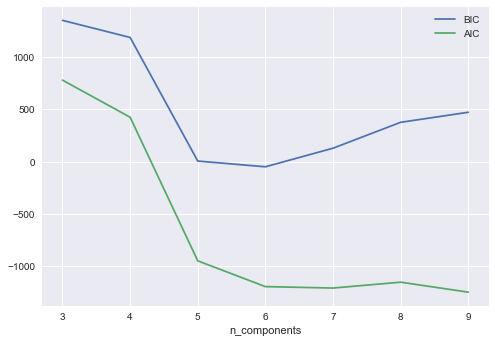

In [387]:
plt.show()

# do 5 clusters (using this approach!)

In [388]:
# bestGMM = GMM_models[3]
bestGMM = GMM_models[2]
# bestGMM = GMM_models[1]
bestGMM_center = pd.concat([pd.DataFrame(bestGMM.means_),pd.DataFrame(bestGMM.weights_).rename(columns={0:'weight'})],axis=1)

In [389]:
bestGMM_center = bestGMM_center.reset_index().rename(columns={'index':'cluster'})

In [390]:
bestGMM_center

cluster         0         1         2         3         4         5  \
0        0  0.063900  0.652237 -0.395343  0.097934 -0.351738 -0.137406   
1        1  0.285626  0.404191 -0.293022  0.018476 -0.351738 -0.245416   
2        2 -1.518068 -2.234977  2.215884 -1.494686  0.121531  0.068120   
3        3  0.198936  0.354904 -0.253242  0.070448  2.816532 -0.137203   
4        4  0.336903  0.278340 -0.523769  0.649568 -0.351738  0.335911   

          6         7         8         9    weight  
0 -0.331243 -0.349475  2.145492 -0.037071  0.118519  
1 -0.208964 -0.214686 -0.377416  0.886007  0.340749  
2  0.010286  0.027666  0.027764  0.061003  0.148148  
3 -0.040676  0.433170 -0.170691 -0.661517  0.088889  
4  0.370619  0.236985 -0.377416 -0.815782  0.303694

In [391]:
# nameDict = {x:sd_fields.columns[x] for x in range(10)}

In [ ]:
nameDict = {0:'Solo forward',1:'Cooperative',2:'Dodger',3:'Star player', 4: 'Efficient star-shooters', 'Average'}

In [392]:
sns.heatmap(bestGMM_center.set_index('cluster').rename(columns = nameDict),annot=True)

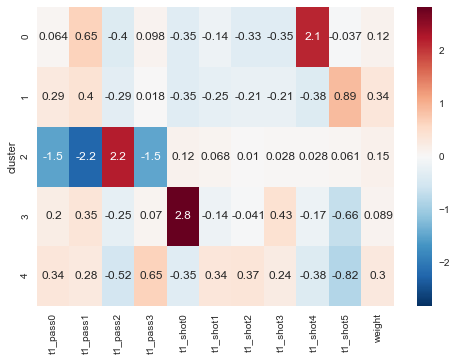

In [393]:
plt.show()

In [394]:
# cluster 0 (generally good cooperative teams, most likely big): most important attribute: has superstar (though not most efficient and wasted some opportunities) + tons of coordinator
# cluster 1: has efficient shooters and good at cooperation, do not really have stars but usually does better than average teams, generally decent cooperation 
# cluster 2: (worst performing teams): dodgers, very low on coordination and etc
# cluster 3 (best team of value): team has efficient and well-performing shooters who do not consume too many opportunities, and has high coordination and offensive duel.
# cluster 4: (average) have team playing the ball, having good ball flow and no dodgers, but do not have good shooters to shoot (shot1, shot2 high)

# Now predict

In [396]:
full_data_selected['cluster'] = bestGMM.predict(sd_fields)

In [397]:
full_data_selected.columns

Index(['team_id', 'season', 't1_pass0', 't1_pass1', 't1_pass2', 't1_pass3',
       't1_shot0', 't1_shot1', 't1_shot2', 't1_shot3', 't1_shot4', 't1_shot5',
       'cluster'],
      dtype='object')

# Combine and make cases of teams

In [398]:
fields = ['team_id', 'team', 'season']
teams_readin = pd.read_csv('MLS.csv', usecols = fields, encoding='latin-1')

In [399]:
teams_dp_dup = teams_readin.drop_duplicates()

In [400]:
teams_dp_dup.head(5)

season  team_id                  team
0     2012-2013.csv     1897        Houston Dynamo
1     2012-2013.csv     1230             LA Galaxy
1564  2012-2013.csv     3500   Seattle Sounders FC
5276  2012-2013.csv     1326           D.C. United
8718  2012-2013.csv     1131  San Jose Earthquakes

In [401]:
full_final = pd.merge(full_data_selected, teams_dp_dup, how='left', on = ['team_id', 'season'])

# Try the most recent season and get a case

In [417]:
recent = full_final[full_final['season'] == '2017-2018.csv'].sort_values('cluster')

In [418]:
recent.head(50)

team_id         season  t1_pass0  t1_pass1  t1_pass2  t1_pass3  t1_shot0  \
132     9668  2017-2018.csv  1.500000  6.500000  1.000000  5.000000  0.000000   
110     2077  2017-2018.csv  1.818182  7.818182  0.000000  4.363636  0.000000   
47      1207  2017-2018.csv  2.304348  7.565217  0.000000  4.043478  0.000000   
128     6900  2017-2018.csv  2.428571  6.142857  1.000000  4.142857  0.000000   
124     5513  2017-2018.csv  3.000000  7.428571  0.000000  3.571429  0.000000   
120     3500  2017-2018.csv  3.000000  7.333333  0.000000  3.500000  0.000000   
103     1903  2017-2018.csv  4.222222  5.333333  1.000000  3.444444  0.000000   
89      1897  2017-2018.csv  3.411765  7.647059  0.411765  2.529412  0.000000   
82      1708  2017-2018.csv  3.500000  6.166667  0.833333  3.388889  0.000000   
130     6977  2017-2018.csv  2.333333  7.666667  0.333333  2.666667  0.000000   
5        399  2017-2018.csv  2.756757  7.297297  0.027027  3.729730  0.000000   
40      1131  2017-2018.csv  2.035714  5.785714  0.464286  5.357143  0.000000   
26       454  2017-2018.csv  2.885714  8.257143  0.000000  2.685714  0.000000   
75      1616  2017-2018.csv  3.388889  6.055556  0.000000  4.500000  0.000000   
19       436  2017-2018.csv  4.354839  5.322581  0.709677  3.516129  0.741935   
61      1326  2017-2018.csv  3.095238  5.476190  1.000000  4.238095  0.000000   
54      1230  2017-2018.csv  3.347826  6.086957  1.086957  3.217391  0.000000   
96      1899  2017-2018.csv  2.909091  5.909091  1.090909  4.090909  0.000000   
33       928  2017-2018.csv  1.464286  5.535714  1.000000  5.821429  0.000000   
12       421  2017-2018.csv  2.000000  4.764706  1.029412  5.558824  0.000000   
68      1581  2017-2018.csv  2.545455  7.409091  1.045455  2.454545  0.000000   

     t1_shot1  t1_shot2  t1_shot3  t1_shot4  t1_shot5  cluster  \
132  0.000000  0.000000  1.000000  1.000000  0.000000        0   
110  0.727273  0.000000  0.545455  0.909091  0.909091        0   
47   1.000000  0.826087  0.217391  1.000000  0.913043        0   
128  0.000000  0.285714  0.000000  0.000000  1.000000        1   
124  0.428571  0.000000  0.000000  0.000000  1.000000        1   
120  0.166667  0.000000  0.833333  0.000000  1.000000        1   
103  0.555556  1.444444  0.000000  0.000000  2.000000        1   
89   0.000000  1.352941  0.823529  0.000000  1.647059        1   
82   0.000000  0.000000  1.166667  0.000000  1.000000        1   
130  0.666667  0.333333  0.333333  0.000000  1.000000        1   
5    0.000000  0.000000  0.540541  0.000000  0.945946        1   
40   0.750000  0.000000  0.321429  0.000000  0.964286        1   
26   0.514286  0.000000  1.685714  0.000000  1.000000        1   
75   0.555556  0.833333  1.055556  0.000000  0.666667        1   
19   0.322581  0.967742  0.838710  0.000000  0.000000        3   
61   1.809524  0.000000  0.619048  0.000000  0.000000        4   
54   2.782609  0.000000  0.391304  0.000000  0.000000        4   
96   0.000000  2.181818  0.272727  0.000000  0.000000        4   
33   1.214286  1.785714  0.178571  0.000000  0.000000        4   
12   1.852941  1.352941  0.323529  0.000000  0.000000        4   
68   1.363636  0.545455  0.727273  0.000000  0.000000        4   

                       team  
132        New York City FC  
110              Toronto FC  
47             Chicago Fire  
128         Orlando City SC  
124      Philadelphia Union  
120     Seattle Sounders FC  
103               FC Dallas  
89           Houston Dynamo  
82   Vancouver Whitecaps FC  
130     Minnesota United FC  
5        New York Red Bulls  
40     San Jose Earthquakes  
26         Columbus Crew SC  
75          Montreal Impact  
19          Colorado Rapids  
61              D.C. United  
54                LA Galaxy  
96           Real Salt Lake  
33   New England Revolution  
12     Sporting Kansas City  
68         Portland Timbers